# GLODAP global map

In [7]:
import numpy as np
from cmocean import cm
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

In [8]:
df = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')

In [9]:
tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])


tSAL = np.array(df['SAL'][:])
tTEMP = np.array(df['TEMP'][:])
tPRES = np.array(df['PRES'][:])


# dens = seawater.dens(tSAL,tTEMP,tPRES)
# tDIC_umolkg = tDIC*1000/dens
# tALK_umolkg = tALK*1000/dens

tLAT = np.array(df['LAT'][:])
tLON = np.array(df['LON'][:])
tYEAR = np.array(df['YR'])
tMONTH = np.array(df['MONTH'])
tSTATION = np.array(df['STATION'])
tY = np.array(df['Y'])
tX = np.array(df['X'])
tZ = np.array(df['Zdep'])
tDP = np.array(df['DP'])
tREG = np.array(df['REG'])
tSEAS = np.zeros_like(tMONTH)
tSEAS[(tMONTH == 12) | (tMONTH <3)] = 1 #summer
tSEAS[(tMONTH >= 3) & (tMONTH <6)] = 2 #autumn
tSEAS[(tMONTH >= 6) & (tMONTH <9)] = 3 #winter
tSEAS[(tMONTH >= 9) & (tMONTH <12)] = 4

In [10]:
print(df.head(5))

   Unnamed: 0      YR  MONTH          DIC          ALK     SAL    TEMP   PRES  \
0           0  1972.0   10.0  2035.037339  2418.910077  36.056  26.660    9.0   
1           1  1972.0   10.0  2277.314363  2364.824183  34.638   6.894  521.0   
2           2  1972.0   10.0  2246.528517  2362.816984  34.662   7.582  446.0   
3           3  1972.0   10.0  2256.026578  2365.073007  34.754   8.321  376.0   
4           4  1972.0   10.0  2235.485978  2366.077845  34.872   9.481  297.0   

     LAT     LON     Y      X           Z  Zdep      DP  REG  STATION  CRUISE  
0 -0.987 -34.035  71.0  124.0    4.999938   0.0  8265.0  2.8     46.0   236.0  
1  3.945 -38.517  80.0  122.0  511.534765  19.0  8999.0  2.8     40.0   236.0  
2  3.945 -38.517  80.0  122.0  511.534765  19.0  8999.0  2.8     40.0   236.0  
3  3.945 -38.517  80.0  122.0  364.303040  18.0  8999.0  2.8     40.0   236.0  
4  3.945 -38.517  80.0  122.0  272.476722  17.0  8999.0  2.8     40.0   236.0  


In [11]:
print(len(np.unique(tSTATION)))

3188


# Frequency plot

In [12]:
import seaborn as sns


In [13]:
fDIC = df[df.DIC> -999]
fDIC = np.array(fDIC['DIC'][:])

mean_DIC = np.mean(fDIC)
print(mean_DIC)

median_DIC = np.median(fDIC)
print(median_DIC)

DIC_STD = np.std(fDIC)
print(DIC_STD)

2258.7805361388655
2258.643020771975
126.43511406965985


Text(0, 0.5, 'Frequency')

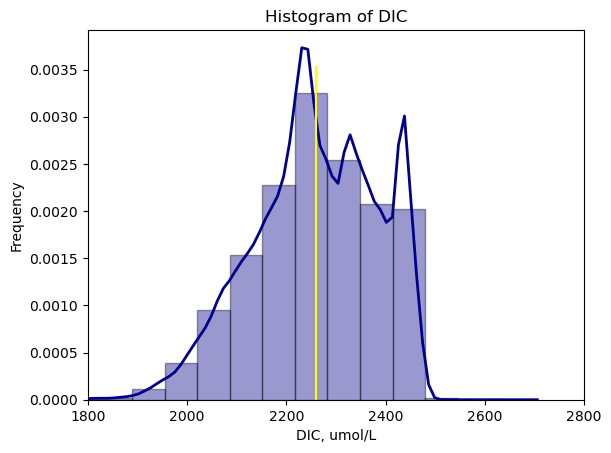

In [14]:
# seaborn histogram
fig, ax = plt.subplots()

sns.distplot(fDIC, hist=True, kde=True, 
            bins=int(180/5),
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})


ax.axvline(x=mean_DIC, ymin=0.0, ymax=0.9, color='r')
ax.axvline(x=median_DIC, ymin=0.0, ymax=0.9, color='yellow')
# ax.axvline(mean_DIC, mean_DIC-DIC_STD, color='#E69F00', alpha=0.5)

# Add labels
plt.xlim(1800,2800)
plt.title('Histogram of DIC')
plt.xlabel('DIC, umol/L')
plt.ylabel('Frequency')

In [15]:
fALK = df[df.ALK> -999]
fALK = np.array(fALK['ALK'][:])

mean_ALK = np.mean(fALK)
print(mean_ALK)

median_ALK = np.median(fALK)
print(median_ALK)

ALK_STD = np.std(fALK)
print(ALK_STD)

2400.0350473635526
2393.774764527549
78.71756935432269


Text(0, 0.5, 'Frequency')

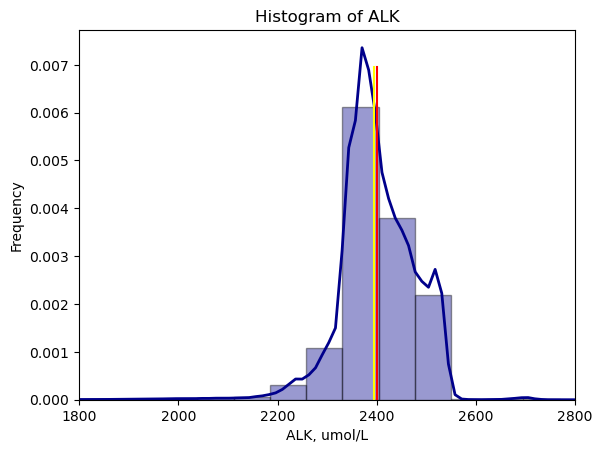

In [16]:
# seaborn histogram
fig, ax = plt.subplots()

sns.distplot(fALK, hist=True, kde=True, 
            bins=int(180/5),
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})


ax.axvline(x=mean_ALK, ymin=0.0, ymax=0.9, color='r')
ax.axvline(x=median_ALK, ymin=0.0, ymax=0.9, color='yellow')
# ax.axvline(mean_ALK, mean_ALK-ALK_STD, color='#E69F00', alpha=0.5)

# Add labels
plt.xlim(1800,2800)
plt.title('Histogram of ALK')
plt.xlabel('ALK, umol/L')
plt.ylabel('Frequency')

# Global plot

In [17]:
import cartopy.crs as ccrs
from cartopy import crs, feature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

    Filters 
        - TA and DIC, TEMP, SAL should exist, depth < 500, TA-DIC conditions, etc, filt_comp is a comprehensive filter of everything

In [18]:
#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-999) & (~np.isnan(tTEMP))
filt_PRES = (tPRES >-999) & (~np.isnan(tPRES))
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)
# filt_OXY = (tOXY > -999) & (~np.isnan(tOXY))
# filt_AOU = (tAOU>-999) & (~np.isnan(tAOU))
filt_YEAR = (tYEAR > 1990)

# #bottom depth relatively shallow <
# filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
# #year is modern
# filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL

# filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & filt_TEMP & filt_DIC & filt_ALK

filt_comp =  filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR #& filt_DEPTH2 & filt_AOU



#? why tDIC+50

In [19]:

tALK_DIC = tALK-tDIC
tALK_DIC2 = tALK-(tDIC+50)
filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC2 = (np.abs(tALK_DIC2) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

#? ? to alternative 'tBotdepth' -- 'tZ'

#tBOTdepth = np.array(df['bottomdepth'][:])

#tGEO = np.zeros_like(tBOTdepth)


In [20]:
###### manually assign geolocations
#? ? to alternative 'tBotdepth' -- 'tZ'
#tGEO = np.zeros_like(tBOTdepth)

tGEO = np.zeros_like(tZ)

#canadian arctic
westlon = -148; eastlon = -50; southlat = 60; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 1

#euro arctic
westlon = -30; eastlon = 91; southlat = 70; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 2
#atlantic 1
westlon = -50; eastlon = 30; southlat = 0; northlat = 70
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#atlantic 2
westlon = -100; eastlon = -50; southlat = 0; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#siberian arctic
westlon = 91; eastlon = 180; southlat = 68; northlat = 91
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 4
#pacific coast
westlon = -140; eastlon = -100; southlat = 10; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 5
#Russian-Alaskan Interface
westlon = -180; eastlon = -148; southlat = 50; northlat = 90
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 6
#Kamchatka Region
westlon = 120; eastlon = 180; southlat = 48; northlat = 68
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 7
#Japan and China
westlon = 120; eastlon = 180; southlat = 10; northlat = 48
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 8
#SO
westlon = -180; eastlon = 180; southlat = -90; northlat = -60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 9

# Devided into different zone

In [21]:
PLACES_withdat = {
'Canadian Arctic': { 'geodat': 1, 'colour': 'blueviolet', 'name':'Canadian Arctic'},
'European Arctic': { 'geodat': 2, 'colour': 'darkorange', 'name':'European Arctic'},
'N. Atlantic': { 'geodat': 3, 'colour': 'red', 'name':'N. Atlantic'},
'Siberian Arctic': { 'geodat': 4, 'colour': 'dodgerblue', 'name':'Siberian Arctic'},
'Coastal Pacific': { 'geodat': 5, 'colour': 'blue', 'name':'Coastal Pacific'},
'Russian/Alaskan Interface': { 'geodat': 6, 'colour': 'skyblue', 'name':'Russian/Alaskan \n Interface'},
'Kamchatka Region': { 'geodat': 7, 'colour': 'lightsteelblue', 'name':'Kamchatka Region'},
'China/Japan': { 'geodat': 8, 'colour': 'steelblue', 'name':'China/Japan'},
'Southern Ocean': { 'geodat': 9, 'colour': 'green', 'name':'Southern Ocean'},
'Everything Else': { 'geodat': 0, 'colour': 'grey', 'name':'Everything Else'},
}

list_places = ['Everything Else','Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',]

print(list_places)

['Everything Else', 'Canadian Arctic', 'European Arctic', 'N. Atlantic', 'Siberian Arctic', 'Coastal Pacific', 'Russian/Alaskan Interface', 'Kamchatka Region', 'China/Japan', 'Southern Ocean']


# Availability Global ovservation

Text(0.5, 1.0, 'Available global DIC and TA measurements, GLODAPv2.2022')

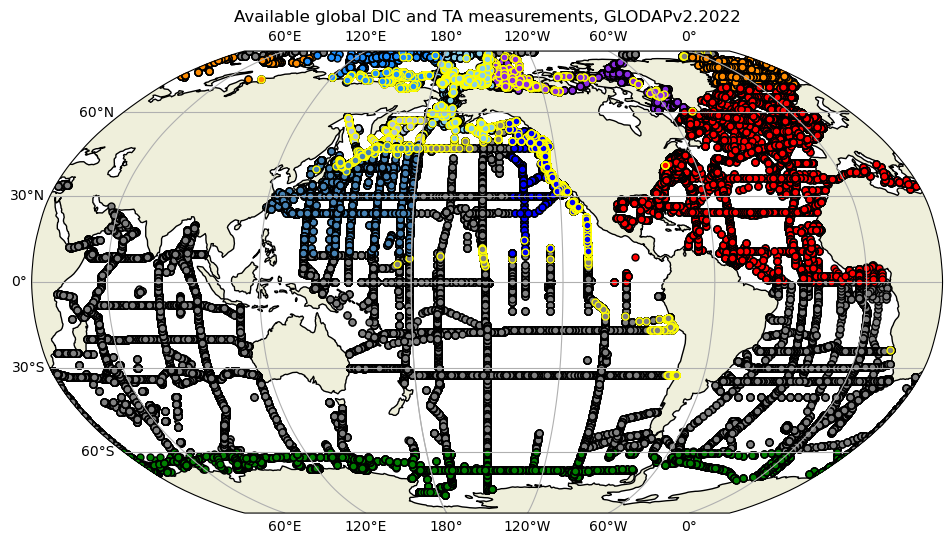

In [22]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-150.0), )
ms = 10
# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.coastlines(facecolor = 'k')
# ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='darkgray'))
ax.add_feature(feature.LAND)

for i in range(0,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    #print(tLON[filt_comp & (tGEO == geotag)])
    ax.plot(tLON[filt_comp & (tGEO == geotag)],\
            tLAT[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', markeredgecolor = 'k', markeredgewidth = 1,\
            markersize = ms, linestyle = '',\
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
    ax.plot(tLON[filt_comp & filt_ALK_DIC & (tGEO == geotag)],\
            tLAT[filt_comp &  filt_ALK_DIC & (tGEO == geotag)],\
           color = tcol, marker = '.', markersize = ms, linestyle = '',\
            markeredgecolor = 'yellow', markeredgewidth = 1,
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
# gl = ax.gridlines(draw_labels=False, xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 15))
# gl.rotate_labels = False
# gl.top_labels = False
# gl.bottom_labels = False

gl = ax.gridlines(draw_labels=True)
gl.rotate_labels = False
# gl.top_labels = False
gl.left_labels = gl.bottom_labels = True
#gl.right_labels = gl.top_labels = False

# gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
# gl.xlabels_top = False
# gl.ylabels_left = False
# gl.ylabels_right=True
# gl.xlines = True
# gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
# gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'color': 'black', 'weight': 'normal'}

# plt.title(r'$\bf{a)}$ Available global DIC and TA measurements, GLODAPv2.2022')
plt.title(r'Available global DIC and TA measurements, GLODAPv2.2022')
# plt.show()
# fig.savefig('./CG_FIGS/FIG_CG_08_map.jpg')

# 1990-2020 surface DIC, TA, and TA-DIC, map

    # ?????? surface? 
    ? Z, Zdep

In [23]:
tZ_2 = np.array(df['Z'])

In [24]:

filt20_DIC_1 = ((tDIC > 2385)  & (~np.isnan(tDIC))) & (tZ_2 < 20)
filt20_DIC_2 = ((tDIC <= 2385) & (tDIC >= 2133 )  & (~np.isnan(tDIC))) & (tZ_2 < 20)
filt20_DIC_3 = ((tDIC < 2133 )  & (~np.isnan(tDIC))) & (tZ_2 < 20)


In [25]:
filt20_ALK_1 = ((tALK > 2478)  & (~np.isnan(tALK))) & (tZ_2 < 20)
filt20_ALK_2 = ((tALK <=2478 ) & (tALK >= 2322 )  & (~np.isnan(tALK))) & (tZ_2 < 20)
filt20_ALK_3 = ((tALK <2322 )  & (~np.isnan(tALK))) & (tZ_2 < 20)

In [26]:
# ??? why use this way to filter TA-DIC?

filt20_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

    DIC

Text(0.5, 1.0, '$\\bf{a)}$ 1990-2020 surface DIC map /n GLODAPv2.2022')

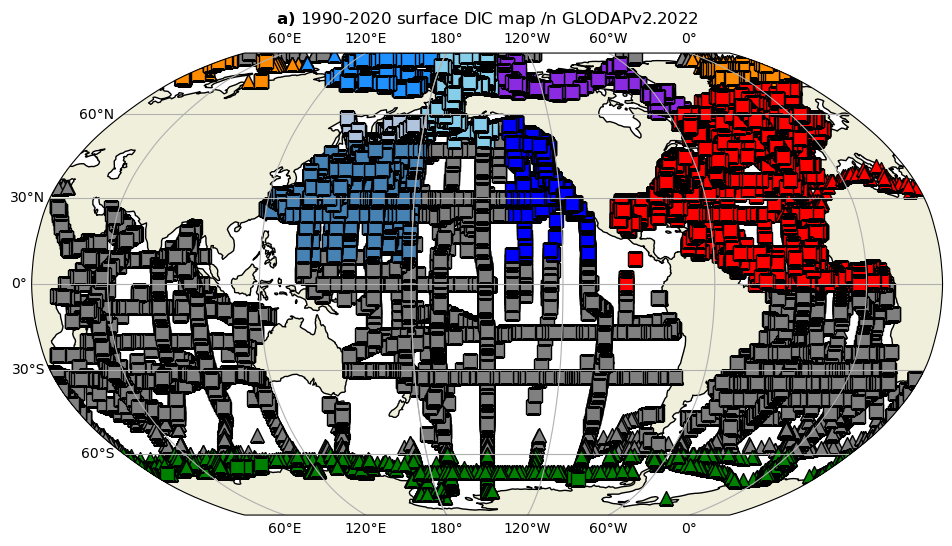

In [27]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-150.0), )
ms = 10
ax.set_global()
ax.coastlines(facecolor = 'k')
ax.add_feature(feature.LAND)


for i in range(0,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])

    ax.plot(tLON[filt20_DIC_1 & (tGEO == geotag)],\
            tLAT[filt20_DIC_1 & (tGEO == geotag)],\
           color = tcol, marker = '.', markeredgecolor = 'k', markeredgewidth = 1,\
            markersize = ms, linestyle = '',\
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
    ax.plot(tLON[filt20_DIC_2 & (tGEO == geotag)],\
            tLAT[filt20_DIC_2 & (tGEO == geotag)],\
           color = tcol, marker = '^', markeredgecolor = 'k', markeredgewidth = 1,\
            markersize = ms, linestyle = '',\
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    
    ax.plot(tLON[filt20_DIC_3 & (tGEO == geotag)],\
            tLAT[filt20_DIC_3 & (tGEO == geotag)],\
           color = tcol, marker = 's' , markeredgecolor = 'k', markeredgewidth = 1,\
            markersize = ms, linestyle = '',\
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())


gl = ax.gridlines(draw_labels=True)
gl.rotate_labels = False
gl.left_labels = gl.bottom_labels = True


plt.title(r'$\bf{a)}$ 1990-2020 surface DIC map /n GLODAPv2.2022')


ALK(TA)

Text(0.5, 1.0, '$\\bf{b)}$ 1990-2020 surface TA map /n GLODAPv2.2022')

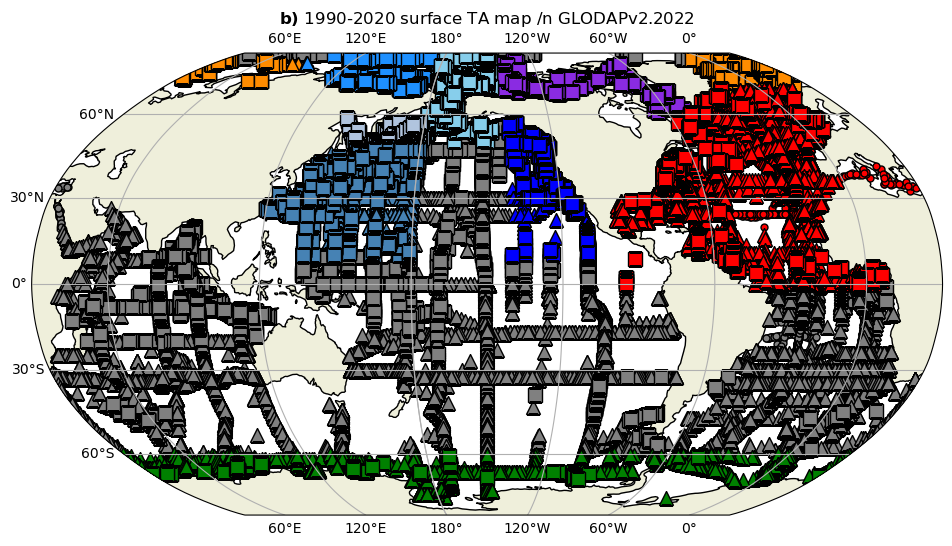

In [28]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-150.0), )
ms = 10
ax.set_global()
ax.coastlines(facecolor = 'k')
ax.add_feature(feature.LAND)

for i in range(0,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    ax.plot(tLON[filt20_ALK_1 &  (tGEO == geotag)],\
            tLAT[filt20_ALK_1 &  (tGEO == geotag)],\
           color = tcol, marker = '.', markersize = ms, linestyle = '',\
            markeredgecolor = 'k', markeredgewidth = 1,
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    ax.plot(tLON[filt20_ALK_2 &  (tGEO == geotag)],\
            tLAT[filt20_ALK_2 &  (tGEO == geotag)],\
           color = tcol, marker = '^', markersize = ms, linestyle = '',\
            markeredgecolor = 'k', markeredgewidth = 1,
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())
    ax.plot(tLON[filt20_ALK_3 &  (tGEO == geotag)],\
            tLAT[filt20_ALK_3 &  (tGEO == geotag)],\
           color = tcol, marker = 's', markersize = ms, linestyle = '',\
            markeredgecolor = 'k', markeredgewidth = 1,
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())


gl = ax.gridlines(draw_labels=True)
gl.rotate_labels = False
gl.left_labels = gl.bottom_labels = True

plt.title(r'$\bf{b)}$ 1990-2020 surface TA map /n GLODAPv2.2022')


TA-DIC

Text(0.5, 1.0, '$\\bf{c)}$ 1990-2020 surface TA-DIC map /n GLODAPv2.2022')

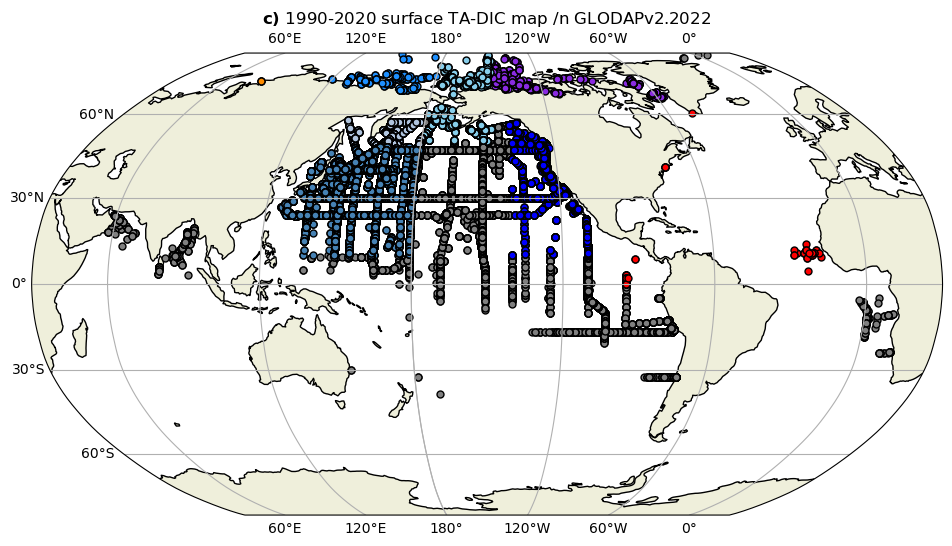

In [29]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-150.0), )
ms = 10
ax.set_global()
ax.coastlines(facecolor = 'k')
ax.add_feature(feature.LAND)

for i in range(0,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    
    ax.plot(tLON[filt_ALK_DIC & (tGEO == geotag)],\
            tLAT[filt_ALK_DIC & (tGEO == geotag)],\
           color = tcol, marker = '.', markersize = ms, linestyle = '',\
            markeredgecolor = 'k', markeredgewidth = 1,
           label = tnam, alpha = 1, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.rotate_labels = False
gl.left_labels = gl.bottom_labels = True

plt.title(r'$\bf{c)}$ 1990-2020 surface TA-DIC map /n GLODAPv2.2022')


# Ovservations in TA vs. DIC space
    - seperate area plots

In [30]:
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i
    
DIC_ar = DIC[0,:]
TA_ar = TA[:,0] 

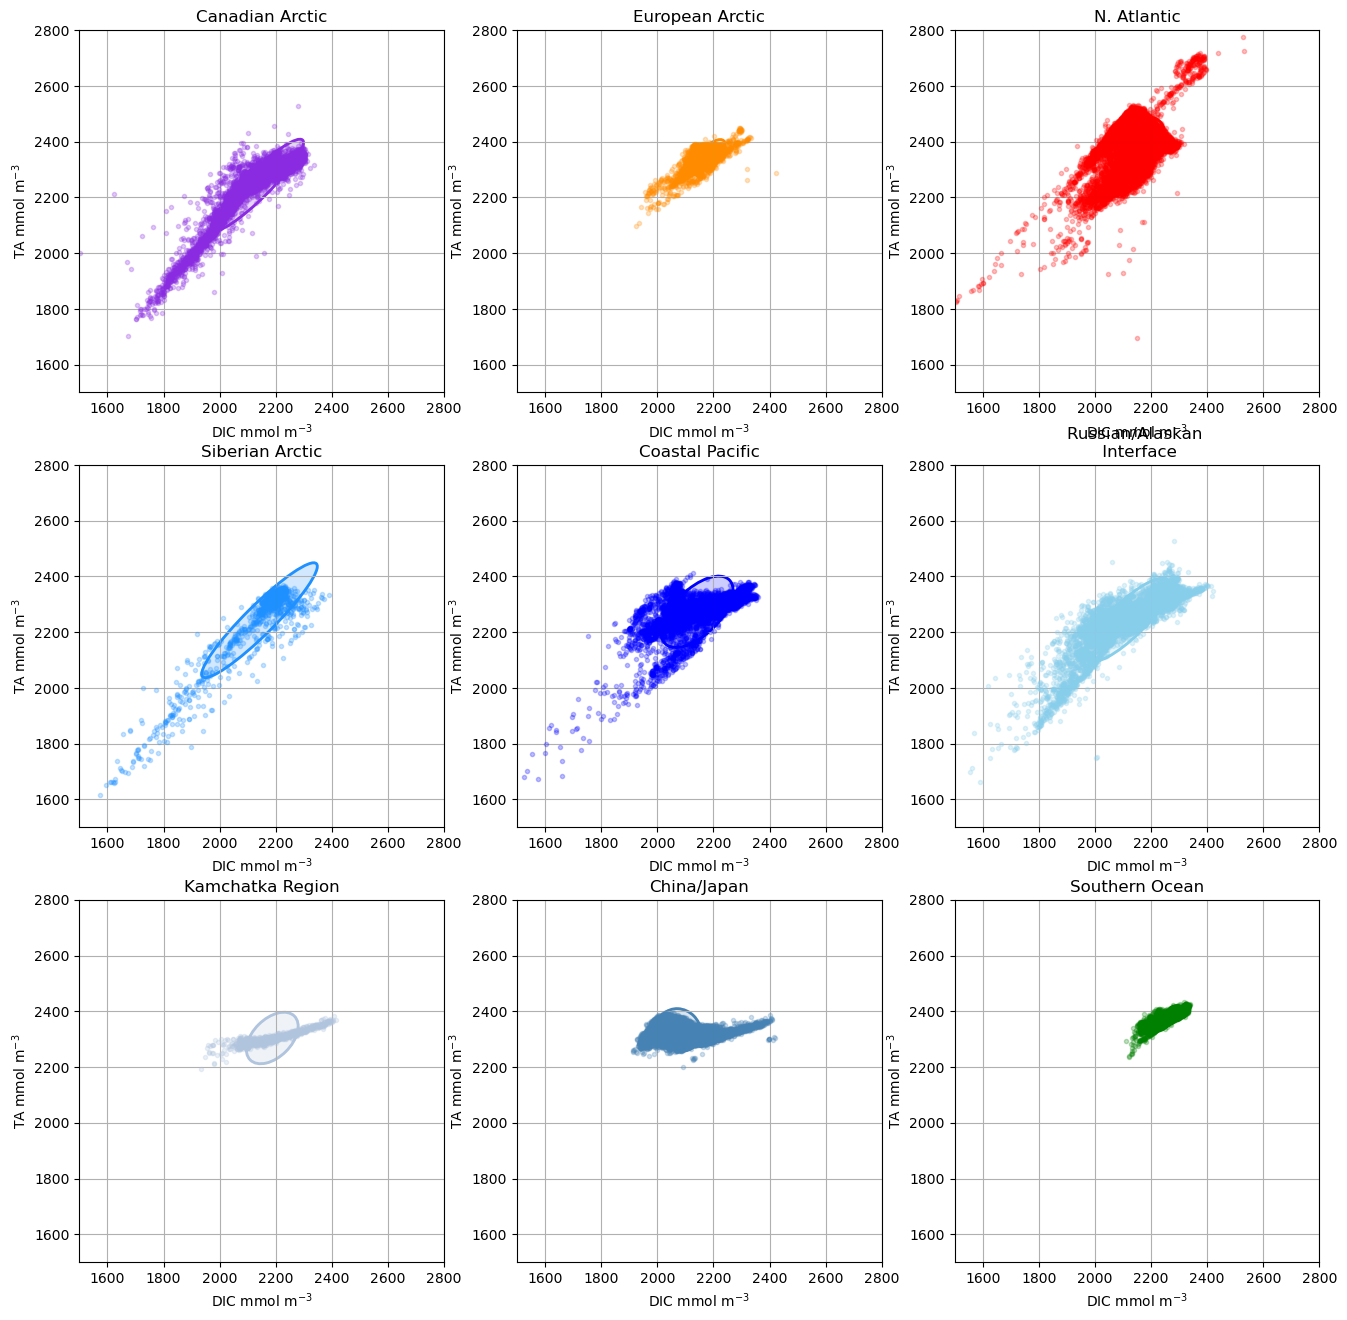

In [31]:
talph = 0.25
fact = 0.8
# omega_lev = 0.2
from matplotlib.patches import Ellipse
fig, axs = plt.subplots(3,3, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    width = 300
    height = 300
    tang = 45
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc='None', lw=2)
    axs[i-1].add_patch(ellipse)

    axs[i-1].plot(x,y,\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)
    
    ellipse = Ellipse(xy=(np.nanmean(x), np.nanmean(y)), width=2*np.nanstd(y+x), height=2*np.nanstd(y-x), angle = 45,
                            edgecolor=tcol, fc= tcol, lw=2, alpha = 0.2)
    axs[i-1].add_patch(ellipse)
    
    axs[i-1].set_xlim([1500,2800])
    axs[i-1].set_ylim([1500,2800])
    axs[i-1].grid()
    axs[i-1].set_title(f'{tnam}')

    axs[i-1].set_ylabel('TA mmol m$^{-3}$')
    axs[i-1].set_xlabel('DIC mmol m$^{-3}$')



# Define Region

Text(0.5, 0.98, 'check that norm of colours works')

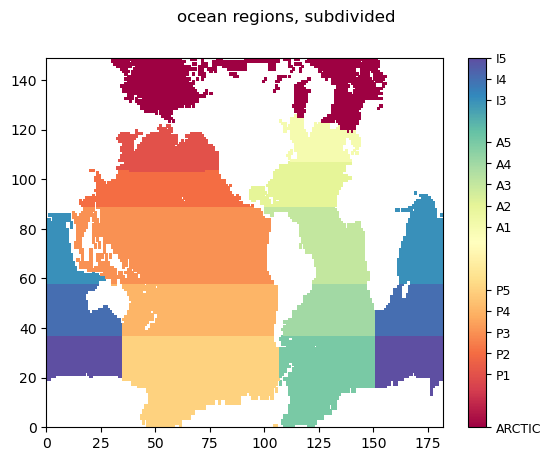

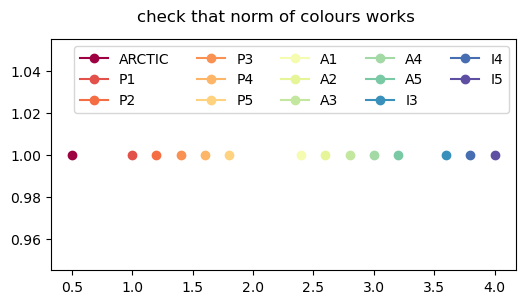

In [32]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('check that norm of colours works')

# Depth plot, region

    Calculating depth profiles
     - clean DIC & ALK <0
     - need more than 2mins

In [33]:
tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])
tDIC[tDIC <0] = np.nan
tALK[tALK <0] = np.nan

In [34]:
for r in range(0,len(regs)):
    grandar = np.zeros([31])
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tREG == tno))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tDIC[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['DICfyDP'] = grandar
    
grandar = np.zeros([31])
q = np.unique(tDP)
storar = np.zeros([len(q),31])
for d in range(0, len(q)):
    tplt = tDIC[tDP == q[d]]; 
    tpres = tPRES[tDP == q[d]];
    tzed = (tZ[tDP == q[d]])
    tzed = tzed.astype(int)
    tzedun = np.unique(tzed)
    if len(tzed) == len(tzedun):
        storar[d,tzed] = tplt
    else: 
        for i in range(0, len(tzedun)):
            storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
storar[storar == 0] = np.nan
grandar = (np.nanmean(storar, axis = 0))
allreg_DICfyDP = grandar

for r in range(0,len(regs)):
    grandar = np.zeros([31])
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tREG == tno))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tALK[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['ALKfyDP'] = grandar
    
grandar = np.zeros([31])
q = np.unique(tDP)
storar = np.zeros([len(q),31])
for d in range(0, len(q)):
    tplt = tALK[tDP == q[d]]; 
    tpres = tPRES[tDP == q[d]];
    tzed = (tZ[tDP == q[d]])
    tzed = tzed.astype(int)
    tzedun = np.unique(tzed)
    if len(tzed) == len(tzedun):
        storar[d,tzed] = tplt
    else: 
        for i in range(0, len(tzedun)):
            storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
storar[storar == 0] = np.nan
grandar = (np.nanmean(storar, axis = 0))
allreg_ALKfyDP = grandar

In [39]:
print(allreg_DICfyDP)

[2138.66209074 2165.21224849 2171.39775244 2177.20554425 2189.55659753
 2195.48350493 2197.31902823 2208.22423847 2213.01719073 2216.64142714
 2215.44241089 2222.47259669 2220.87395368 2229.86326298 2231.83345689
 2237.33611305 2237.56522942 2252.07899303 2257.84153635 2273.06584496
 2279.98888715 2284.70359864 2281.59648871 2278.30838767 2272.66321846
 2269.20528612 2261.18054415 2256.52074116 2251.07812945 2250.04430893
 2259.60014077]


        Depth plots

In [35]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
depths = (tmesh['gdept_1d'][0])

Text(0.5, 0.92, 'mean GLODAPv2.2022 DIC and TA depth profiles by region, µmol/L')

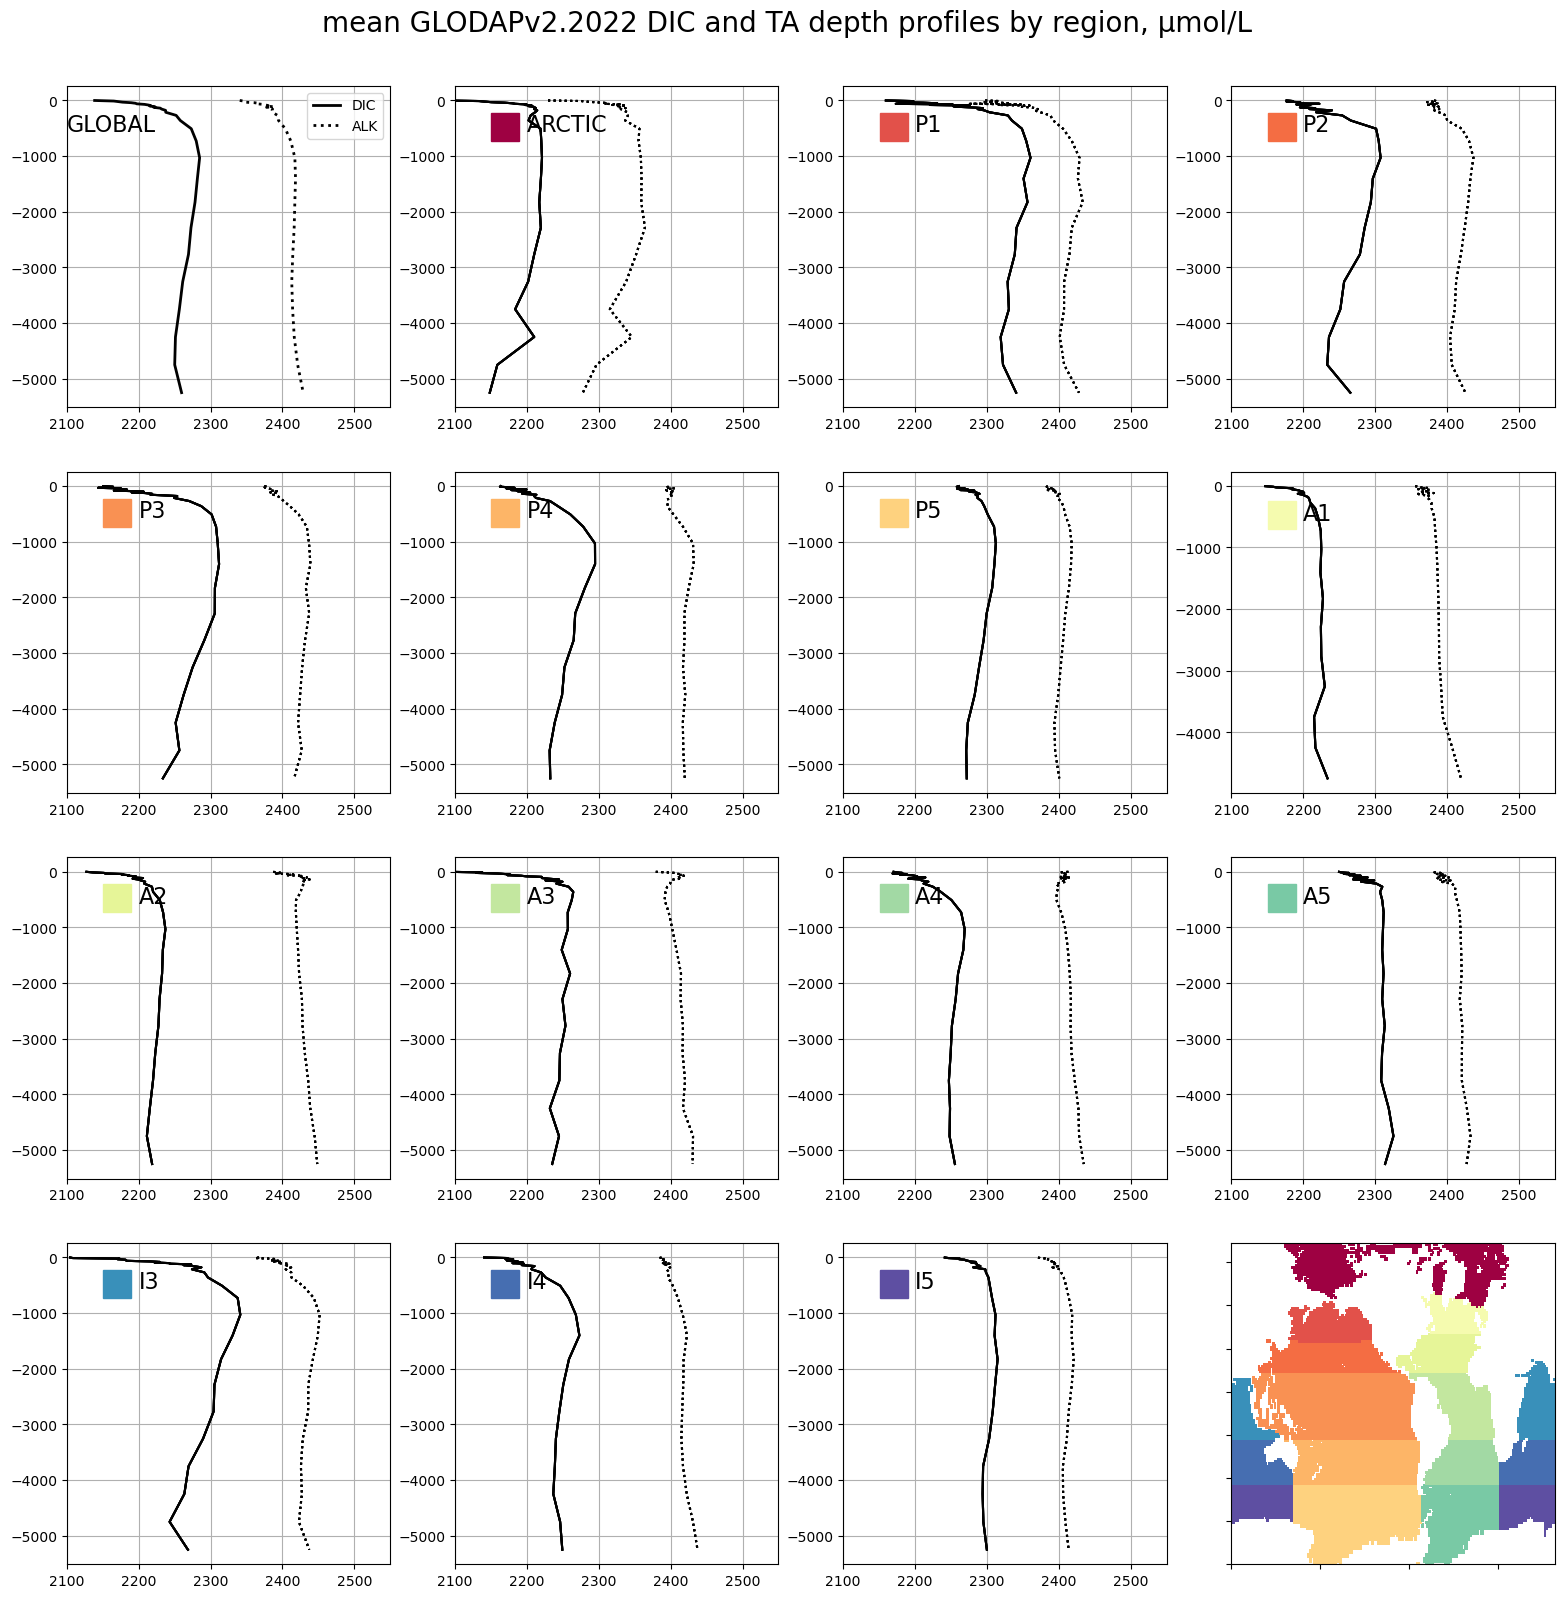

In [36]:
fact = 1.6
fig, axs = plt.subplots(4,4, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


axs[0].plot(allreg_DICfyDP, -depths, color = 'k', linestyle = '-', label = 'DIC', linewidth = 2)
axs[0].plot(allreg_ALKfyDP, -depths, color = 'k', linestyle = ':', label = 'ALK', linewidth = 2)


for i in range(0,len(regs)):
    for r in range(0,4):
        axs[i+1].plot(regdict[regs[i]]['DICfyDP'][:],-depths, color = 'k',linestyle = '-',\
                    )
        axs[i+1].plot(regdict[regs[i]]['ALKfyDP'][:],-depths, color = 'k', linestyle = ':',\
                    )
        
axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])

axs[0].text(2100,-560,'GLOBAL', color = 'k', fontsize = 16)

for i in range(0,len(regs)):
    axs[i+1].plot(2170,-480,marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(2200,-560,regs[i], color = 'k', fontsize = 16)
for i in range(0,len(regs)+1):
    axs[i].set_xlim([2100,2550])
    axs[i].grid()
axs[0].legend(fontsize = 10)

plt.suptitle('mean GLODAPv2.2022 DIC and TA depth profiles by region, µmol/L', fontsize = 20, y = 0.92)

??TA-DIC

In [37]:
allreg_ALK_DICfyDP =  allreg_ALKfyDP - allreg_DICfyDP

for i in range(0,len(regs)):
    for r in range(0,4):
        regdict[regs[i]]['ALK_DICfyDP'] = regdict[regs[i]]['ALKfyDP']-regdict[regs[i]]['DICfyDP']

Text(0.5, 0.92, 'mean GLODAPv2.2022 TA-DIC depth profiles by region, µmol/L')

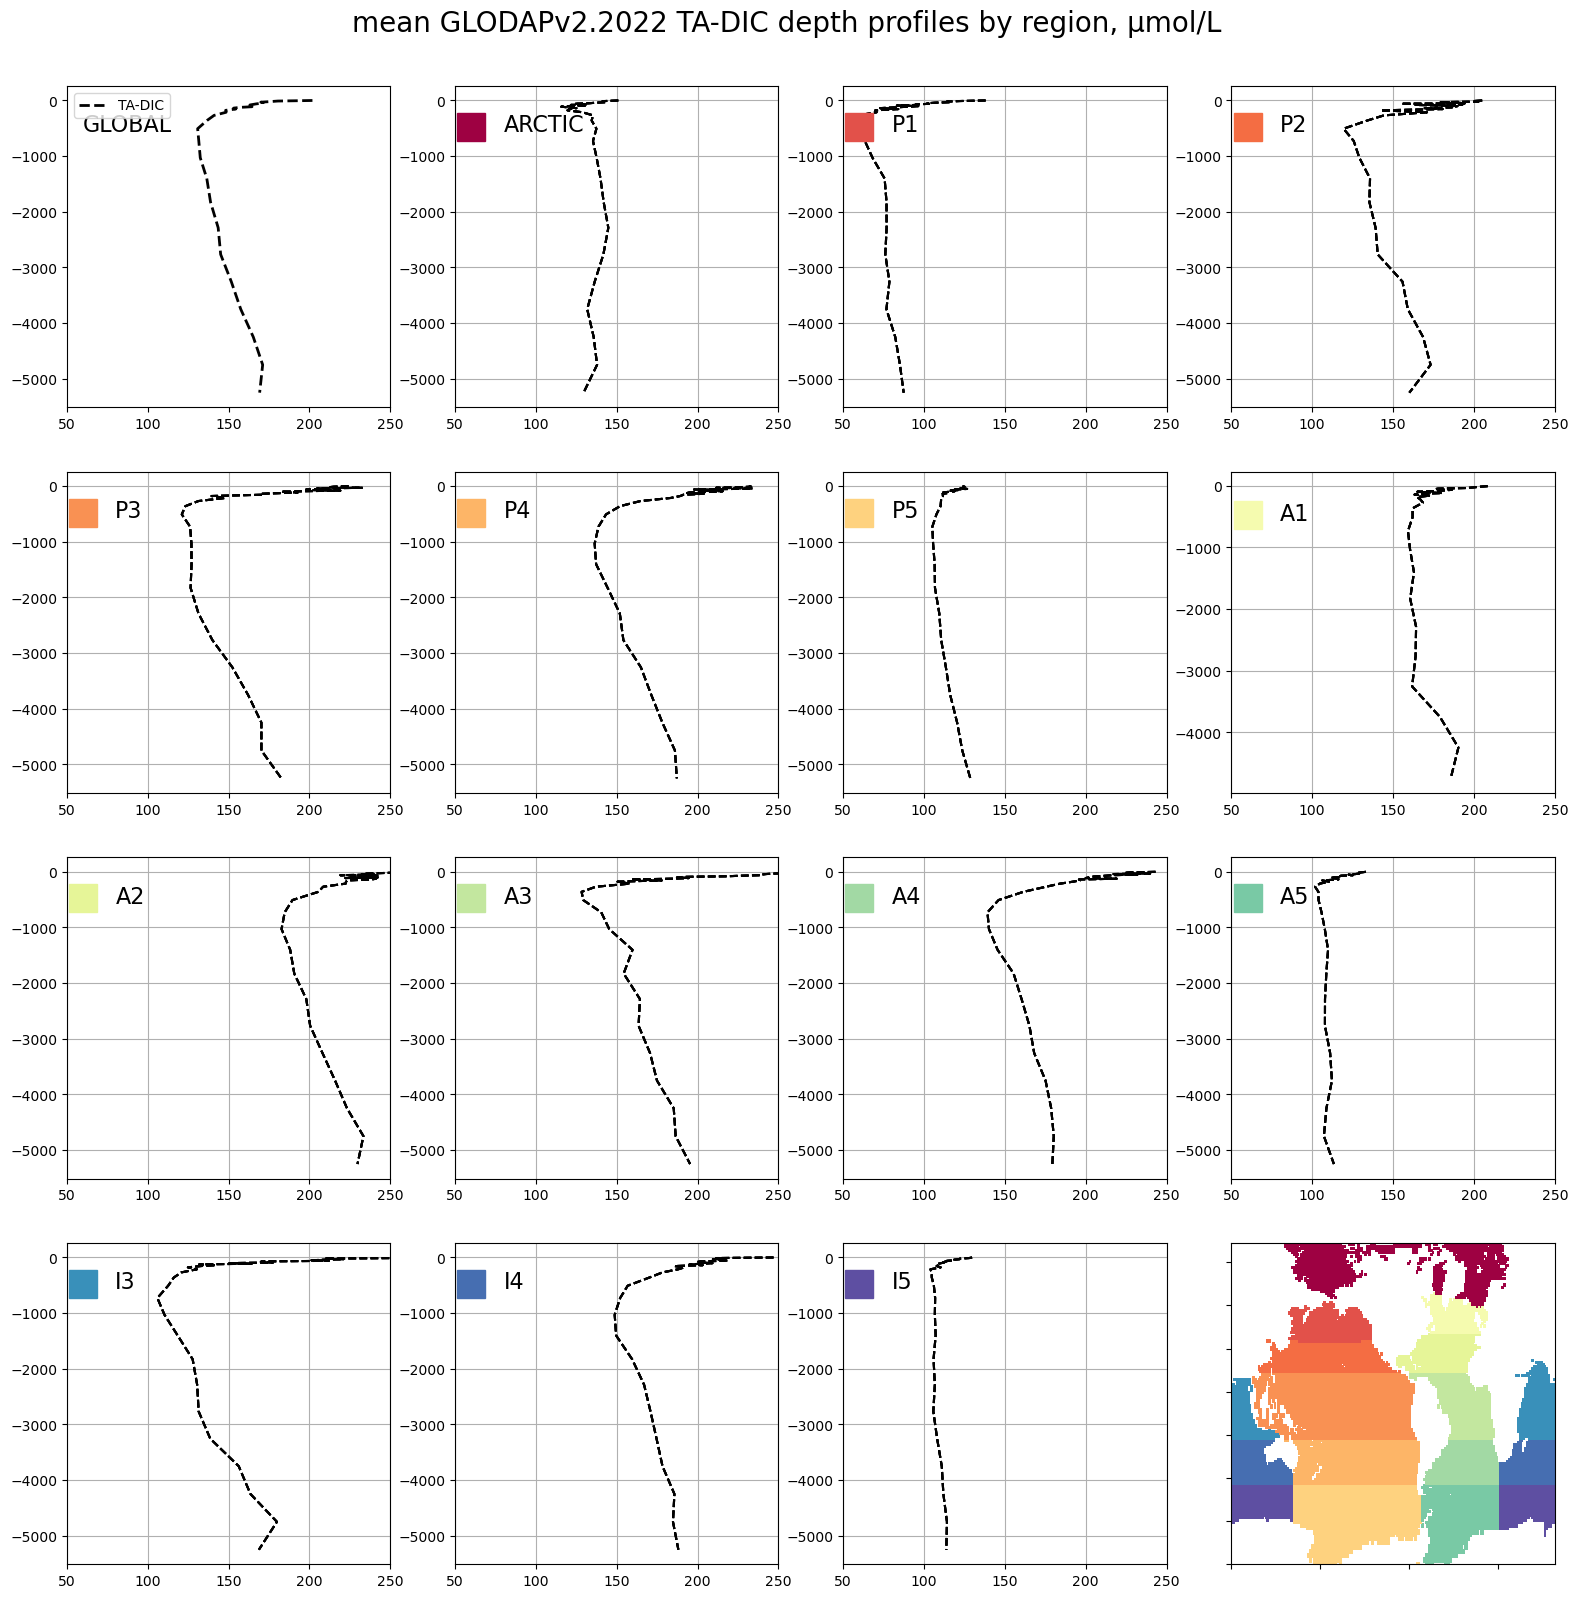

In [38]:
fact = 1.6
fig, axs = plt.subplots(4,4, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


axs[0].plot(allreg_ALK_DICfyDP, -depths, color = 'k', linestyle = '--', label = 'TA-DIC', linewidth = 2)


for i in range(0,len(regs)):
    for r in range(0,4):
        axs[i+1].plot(regdict[regs[i]]['ALK_DICfyDP'][:],-depths, color = 'k',linestyle = '--',\
                    )
        
axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])

for i in range(0,len(regs)):
    axs[i+1].plot(60,-480,marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(80,-560,regs[i], color = 'k', fontsize = 16)
for i in range(0,len(regs)+1):
    axs[i].set_xlim([50,250])
    axs[i].grid()

axs[0].grid()
axs[0].text(60,-560,'GLOBAL', color = 'k', fontsize = 16)
axs[0].legend(fontsize = 10)


plt.suptitle('mean GLODAPv2.2022 TA-DIC depth profiles by region, µmol/L', fontsize = 20, y = 0.92)